# Assets in the rotki database

`rotki` ([rotki.com](https://rotki.com)) is a portfolio management, analytics and accounting application that protects your privacy. It is a local app, the code is open source and available at [github](https://github.com/rotki/rotki).

At rotki, each instance keeps a database that can be found [here](https://github.com/rotki/rotki/blob/develop/rotkehlchen/data/global.db) called `global.db`. It contains information about contracts and assets that can be used by the user when the app is used for the first time. If the app detects that the DB is missing we copy the packaged one so the user has acccess to all this information from the start. We update it periodically with more assets and also the user can add/edit/delete assets and other information from its local copy.

As part of the Advent of crypto Data we are releasing CSV files from this database compiled with all data up to version 1.31.1 of the rotki app to be easily used by others in their apps along with a script to generate them from any version after the one mentioned.

This notebook is a small analysis on the different assets present at the rotki packaged database. This database contains information related to assets in three tables those being

- assets
- common_asset_details
- evm_tokens

The division of the information in those tables follows a design decision to enable the support of assets from many different chains while supporting performant queries in the database and easy upgradability

The database has been exported to four different csv files:

- `evm_tokens.csv` contains information only about evm tokens from the database
- `other_assets.csv` contains information for assets that have their own chain and/or chains that are not supported in rotki directly yet
- `asset_collections.csv` contains information about assets so that we can make groups out of them (say all instances of USDC across chains)
- `multiassets_mappings.csv`contains mapping of assets to the groups they belong to


## Table of contents:
* [Analysis of the EVM tokens in the database](#evm-tokens)
    * [Reading the information from the CSV](#reading-1)
    * [Assets by chain](#by-chain)
    * [Deploying time of the tokens](#deploying)
    * [Tokens with identifiers for oracles](#oracles-1)
    * [Protocol column](#protocol)
* [Other assets](#other-assets)
    * [Reading the dataset](#reading-2)
    * [Oracle distribution of the assets](#dist-oracles-2)
* [Collections of assets](#collections)
* [Conclusion](#conclusion)

In [1]:
import datetime

import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

## Analysis of the EVM tokens in the database <a id="evm-tokens"></a>

The database contains different information for assets. In the case of EVM tokens we have extracted the information that is commonly used in dapps. We provide the chain id, name, symbol, the number of decimals and a timestamp for when the contract was deployed or it started to have price information.

For identifiers we use the CAIPs format, more information for which is available here https://chainagnostic.org/CAIPs/caip-2

### Reading the information from the CSV <a id="reading-1"></a>

In [2]:
df = pl.read_csv('evm_tokens.csv')

the started field is provided as an integer. We will cast it to a datetime object

In [3]:
df = df.with_columns(pl.from_epoch('started', time_unit="s"))

the total number of tokens in the dataset is

In [4]:
len(df)

4494

In [5]:
df.head()

identifier,address,chain,name,symbol,decimals,coingecko,cryptocompare,started,protocol
str,str,i64,str,str,i64,str,str,datetime[μs],str
"""eip155:1/erc20…","""0xB6eD7644C694…",1,"""0xBitcoin""","""0xBTC""",8,"""oxbitcoin""","""0XBTC""",2018-02-06 00:00:00,null
"""eip155:1/erc20…","""0x111111111117…",1,"""1INCH Token""","""1INCH""",18,"""1inch""",null,2020-12-23 18:13:31,null
"""eip155:1/erc20…","""0x0F72714B35a3…",1,"""1SG""","""1SG""",18,"""1sg""",null,2018-12-25 00:00:00,null
"""eip155:1/erc20…","""0xAf30D2a7E90d…",1,"""FirstBlood""","""1ST""",18,"""first-blood""",null,2016-07-09 00:00:00,null
"""eip155:1/erc20…","""0xfDBc1aDc26F0…",1,"""1World""","""1WO""",8,"""1world""",null,2017-11-30 00:00:00,null


### Assets by chain <a id="by-chain"></a>

this asset database has a long history. Since for a long time, rotki supported only ethereum mainnet, most of the tokens that we have in it are ethereum tokens. There are some evm compatible chains for which we started to add assets recently like Celo (42220) that have only one asset.

In [6]:
counts = df['chain'].value_counts().rename({'counts': 'count'})

<Axes: title={'center': 'Number of tokens per chain'}, xlabel='chain', ylabel='count'>

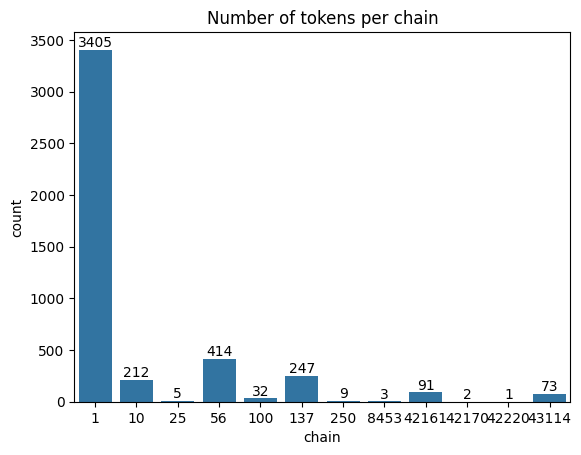

In [7]:
ax = sns.barplot(x='chain', y='count', data=counts)
ax.set_title('Number of tokens per chain')
ax.bar_label(ax.containers[0])
ax

as we can see the dataset has mostly ethereum tokens but some of the most important ones in other chains are also present. The chain with most tokens apart from mainnet is BSC, follow by polygon and optimism.

### Deploying time of the tokens <a id="deploying"></a>

let's now check the distribution of tokens over time according to their started field. The dataset is missing information for some assets in this field so first let's remove those rows that have a null value in this column. The total number of such rows is

In [8]:
len(df) - len(df.filter(~pl.all_horizontal(pl.col('started').is_null())))

1402

In [9]:
deploying_time = df.filter(
   ~pl.all_horizontal(pl.col('started').is_null())
).sort('started').group_by_dynamic('started', every='1mo').agg(pl.col('identifier').count()).rename({'identifier': 'count'})

In [10]:
deploying_time.head()

started,count
datetime[μs],u32
1970-01-01 00:00:00,37
2014-01-01 00:00:00,1
2014-06-01 00:00:00,1
2014-11-01 00:00:00,1
2015-05-01 00:00:00,1


As we can see there is some innacuracy in the data since 37 tokens have a timestamp of 0. Also there are a few tokens existing before the launch of ethereum

In [11]:
df.filter(
   ~pl.all_horizontal(pl.col('started').is_null())
).filter(pl.col('started').is_between(datetime.datetime(1970, 1, 1), datetime.datetime(2015, 7, 15))).sort('started')

identifier,address,chain,name,symbol,decimals,coingecko,cryptocompare,started,protocol
str,str,i64,str,str,i64,str,str,datetime[μs],str
"""eip155:1/erc20…","""0x1bEe44cb0e6C…",1,"""$ amcoc.xyz""","""Visit https://…",18,null,null,1970-01-01 00:00:00,"""spam"""
"""eip155:1/erc20…","""0x4ACbEAb5fFCb…",1,"""Adomy.site""","""Bonus. Visit h…",18,null,null,1970-01-01 00:00:00,"""spam"""
"""eip155:1/erc20…","""0x520b9A2A38ca…",1,"""$ ETH 2.0""","""https://eth2.t…",18,null,null,1970-01-01 00:00:00,"""spam"""
"""eip155:1/erc20…","""0x54718b68d35B…",1,"""$ crLink.app""","""Claim rewards …",18,null,null,1970-01-01 00:00:00,"""spam"""
"""eip155:1/erc20…","""0x8d18a7D965bb…",1,"""$ fdai.xyz""","""Visit https://…",18,null,null,1970-01-01 00:00:00,"""spam"""
"""eip155:1/erc20…","""0xa88ce09448bB…",1,"""MaticMerge.org…","""MaticMerge.org…",18,null,null,1970-01-01 00:00:00,"""spam"""
"""eip155:1/erc20…","""0xB08070Bafc06…",1,"""$ abonus.site""","""880$ Visit htt…",0,null,null,1970-01-01 00:00:00,"""spam"""
"""eip155:1/erc20…","""0xDc09ef6bA2a1…",1,"""$ ETHGiftX.com…","""$ Visit ETHGif…",0,null,null,1970-01-01 00:00:00,"""spam"""
"""eip155:1/erc20…","""0xF394ba49fdf6…",1,"""PepeAir.com""","""PepeAir.com""",0,null,null,1970-01-01 00:00:00,"""spam"""


The database also contains a blacklist of spam assets. Those are the ones marked with the spam protocol. rotki has an autodection system for spam and in addition keeps list at https://github.com/rotki/data/tree/develop/updates/spam_assets that gets pulled and updated with each new release.

Let's show now a graph with the deployment times for the tokens that we have

<Axes: title={'center': 'Number of tokens deployed by month'}, xlabel='started', ylabel='count'>

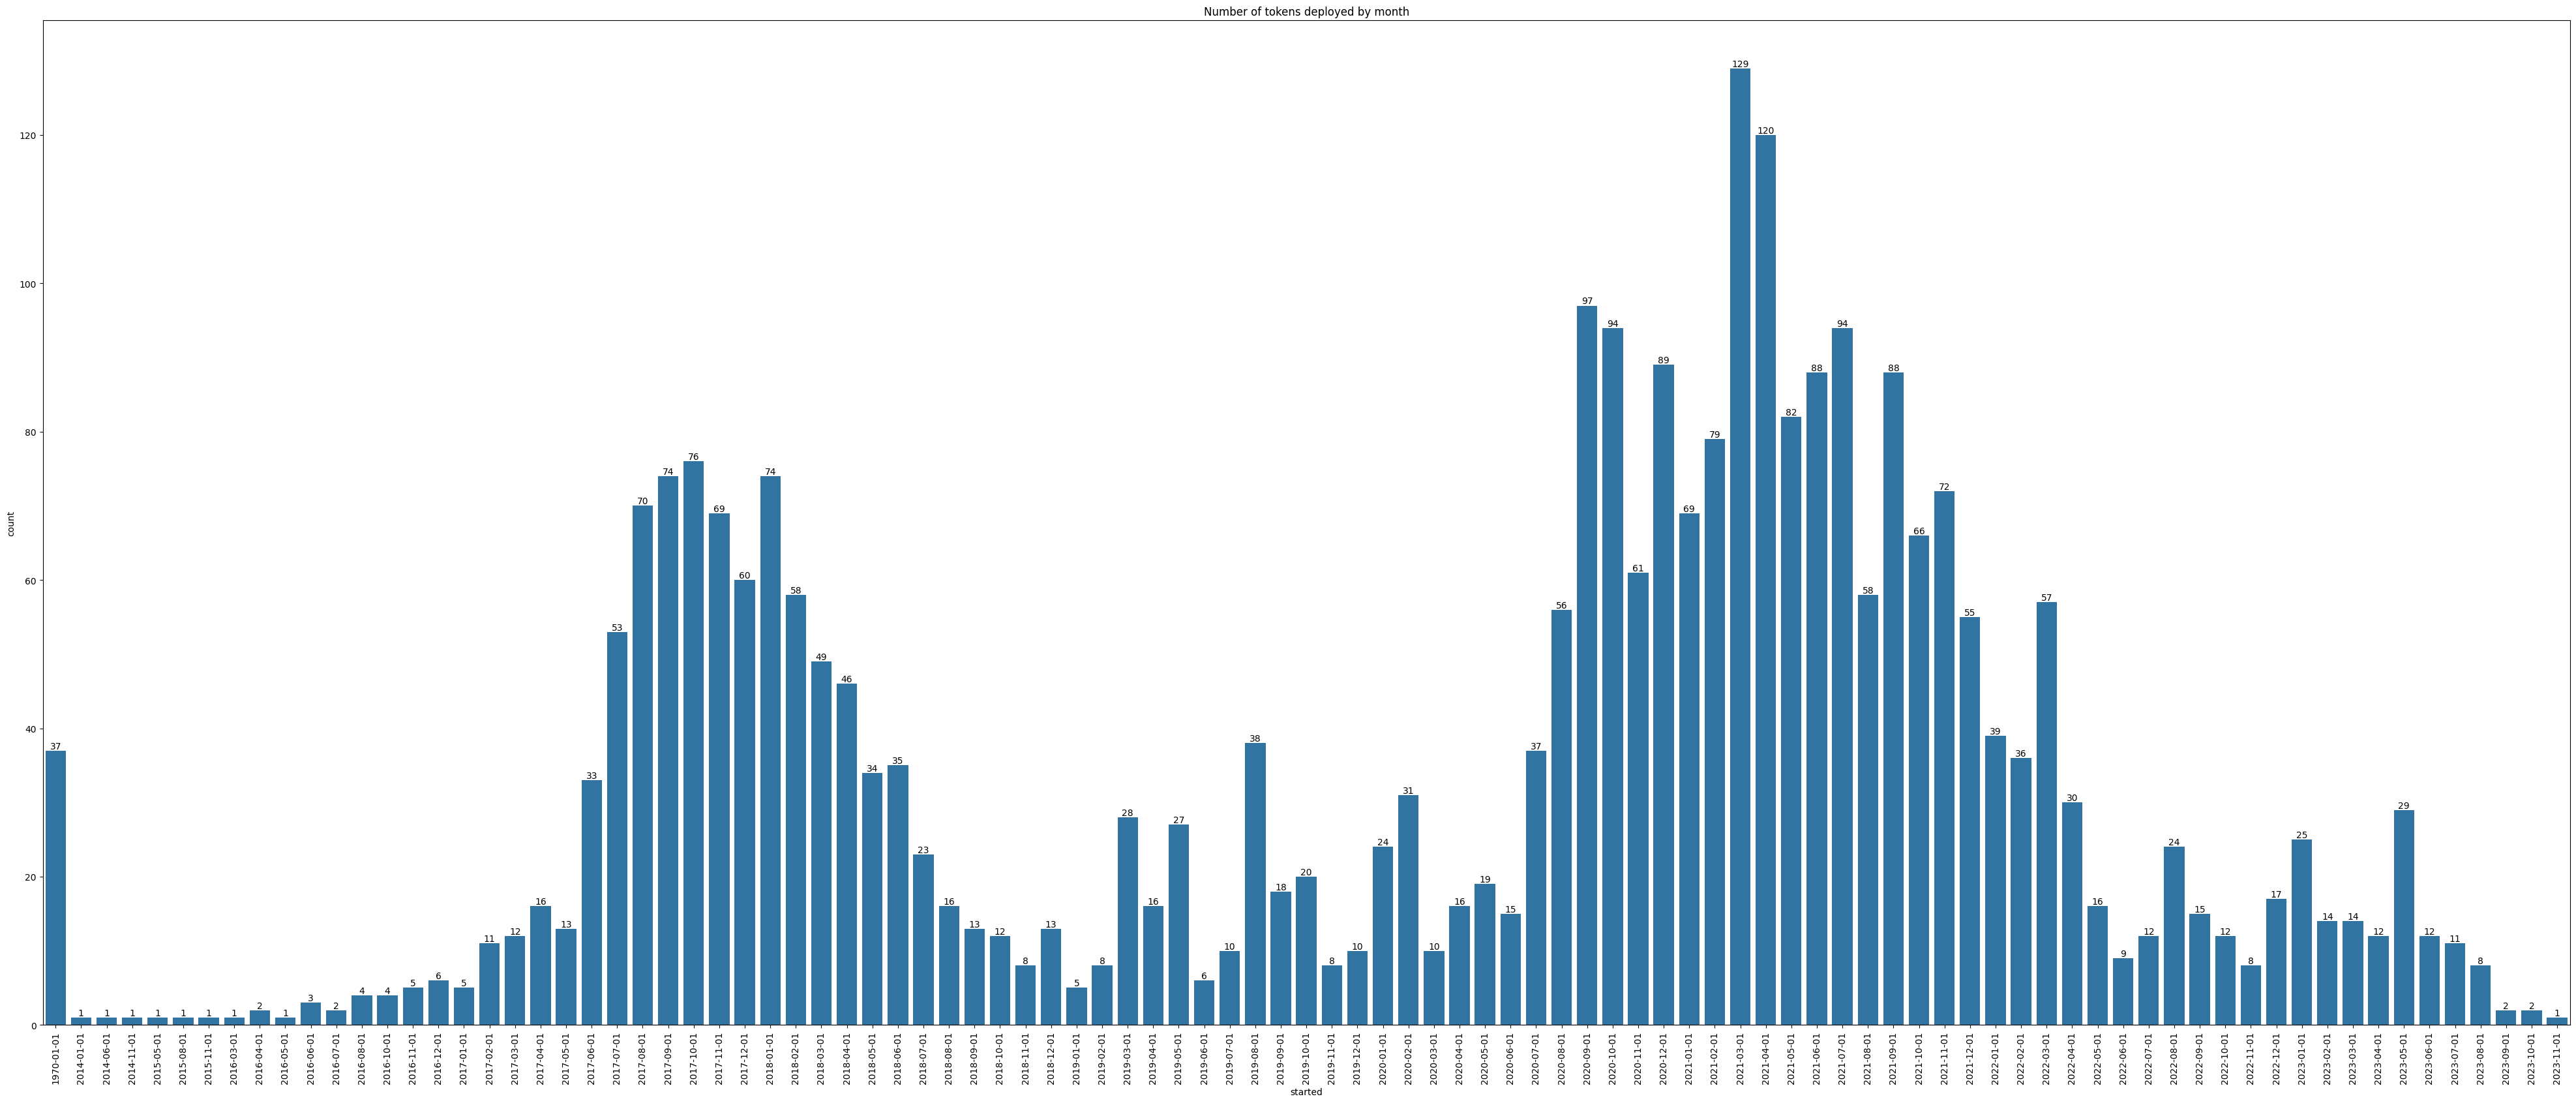

In [12]:
ax = sns.barplot(x='started', y='count', data=deploying_time)
ax.figure.set_size_inches(50,20)
ax.set_title('Number of tokens deployed by month')
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
ax

Run the next cell to save this graph to your system

In [13]:
fig = ax.get_figure()
fig.savefig("out.png", dpi=150, bbox_inches='tight') 

This graph is interesting because we can see that in the second half of 2017 there were a lof of deployments for tokens and the same happens from 2020 to 2022. The first peak happened for around 1 year and the second for 2 years. Also the second peak was more intensive in terms of listings than the first one.

### Tokens with identifiers for oracles <a id="oracles-1"></a>

At rotki we query some prices form on-chain oracles but we also use external APIs like coingecko and cryptocompare to query current and historical prices. To make these queries we need to have the identifiers of the assets on those platforms. Let's check the distribution of tokens with coingecko ids and cryptocompare ids. There are assets that don't have either of them so lets first filter them out

In [14]:
api_oracles = df.filter(~pl.all_horizontal(pl.col('coingecko', 'cryptocompare').is_null()))

In [15]:
api_oracles.head()

identifier,address,chain,name,symbol,decimals,coingecko,cryptocompare,started,protocol
str,str,i64,str,str,i64,str,str,datetime[μs],str
"""eip155:1/erc20…","""0xB6eD7644C694…",1,"""0xBitcoin""","""0xBTC""",8,"""oxbitcoin""","""0XBTC""",2018-02-06 00:00:00,null
"""eip155:1/erc20…","""0x111111111117…",1,"""1INCH Token""","""1INCH""",18,"""1inch""",null,2020-12-23 18:13:31,null
"""eip155:1/erc20…","""0x0F72714B35a3…",1,"""1SG""","""1SG""",18,"""1sg""",null,2018-12-25 00:00:00,null
"""eip155:1/erc20…","""0xAf30D2a7E90d…",1,"""FirstBlood""","""1ST""",18,"""first-blood""",null,2016-07-09 00:00:00,null
"""eip155:1/erc20…","""0xfDBc1aDc26F0…",1,"""1World""","""1WO""",8,"""1world""",null,2017-11-30 00:00:00,null


In [16]:
count_oracles = pl.DataFrame(api_oracles.select(pl.col('cryptocompare', 'coingecko').is_not_null().sum()).to_pandas().T.reset_index()).rename({'index': 'oracle', '0': 'count'})

<Axes: title={'center': 'Number of tokens with crypotocompare and coingecko ids'}, xlabel='oracle', ylabel='count'>

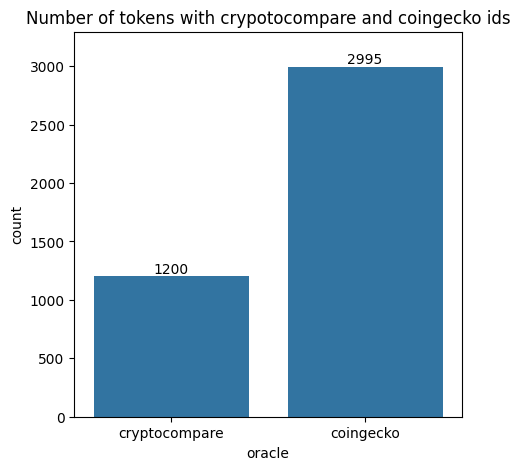

In [17]:
oracles_data = count_oracles
ax = sns.barplot(x='oracle', y='count', data=oracles_data)
ax.figure.set_size_inches(5,5)
ax.margins(y=0.1) # make room for the labels
ax.set_title('Number of tokens with crypotocompare and coingecko ids')
ax.bar_label(ax.containers[0])
ax

As we can see most of the assets have a coingecko id and cryptocompare in general is more conservative when it comes to listing new assets.

It is worth mentioning that some assets get delisted from coingecko if there is no activity for a long time. In this case the id is no longer valid. We keep a list of those edge cases here: https://github.com/rotki/rotki/blob/94f474a66dae4807af2b69029d6607c036c11dad/rotkehlchen/externalapis/coingecko.py#L37

### Protocol column <a id="protocol"></a>

At rotki we also use a protcol column to identify groups of assets belonging to a specific protocols. This is useful for us to identify yearn vaults in decoders, compound tokes, aave tokens etc. We also have a special protocol called `SPAM` which identifies an asset as an EVM spam token.

In [18]:
protocols = df.filter(
   ~pl.all_horizontal(pl.col('protocol').is_null())
).group_by('protocol').agg(pl.col('identifier').count()).rename({'identifier': 'count'})

In [19]:
protocols.head()

protocol,count
str,u32
"""yearn_vaults_v…",195
"""compound""",19
"""yearn_vaults_v…",35
"""curve_pool""",559
"""spam""",207


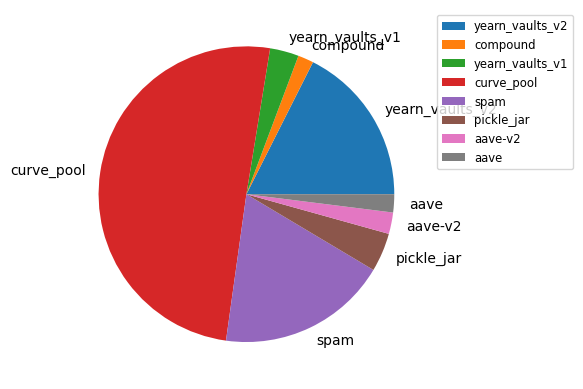

In [20]:
labels = [x[0] for x in protocols.select('protocol').rows()]
protocols.to_pandas().plot.pie(
    y='count',
    ylabel='',
    labels=labels,
    legend=False,
).legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',
)

For curve, yearn and velodrome the information might not be up to date since new pools are constantly deployed. We have a periodic task in the app that updates it for every user by making on chain calls.

## Other assets <a id="other-assets"></a>

We have assets that are not evm tokens and the structure for the csv is a bit different. This is why we provide them in a different file

### Reading the dataset <a id="reading-2"></a>

In [21]:
dfo = pl.read_csv('other_assets.csv').with_columns(pl.from_epoch('started', time_unit="s"))

In [22]:
len(dfo)

895

In [23]:
dfo.head()

identifier,name,symbol,type,coingecko,cryptocompare,started
str,str,str,str,str,str,datetime[μs]
"""1CR""","""1 credit""","""1CR""","""own_chain""",null,null,2014-04-27 00:00:00
"""2GIVE""","""2GIVE""","""2GIVE""","""own_chain""","""2give""",null,2016-04-18 00:00:00
"""ABBC""","""ABBC Coin""","""ABBC""","""own_chain""","""alibabacoin""",null,2018-03-05 00:00:00
"""ABY""","""ArtByte""","""ABY""","""own_chain""","""artbyte""",null,2014-05-01 00:00:00
"""AC""","""AsiaCoin""","""AC""","""own_chain""","""affil-coin""",null,2014-04-20 00:00:00


<Axes: title={'center': 'Number of tokens per chain'}, xlabel='type', ylabel='count'>

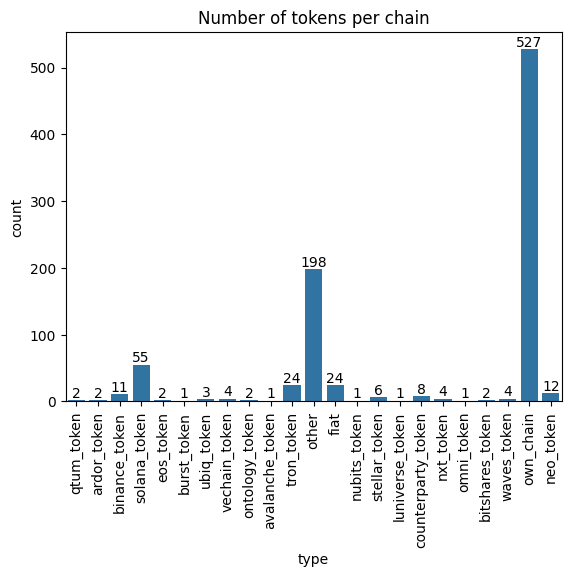

In [24]:
counts = dfo['type'].value_counts().rename({'counts': 'count'})
ax = sns.barplot(x='type', y='count', data=counts)
ax.set_title('Number of tokens per chain')
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
ax

As we can see most of assets are assets like BTC that have their own chain. We have many solana tokens too also with information linking them to their coingecko and cryptocompare ids

### Oracle distribution of the assets <a id="dist-oracles-2"></a>

Similar to what we did with the evm tokens we can study the oracles for this assets

In [25]:
api_oracles = dfo.filter(
   ~pl.all_horizontal(pl.col('coingecko', 'cryptocompare').is_null()) 
)

<Axes: title={'center': 'Number of assets with cryptocompare and coingecko ids'}, xlabel='oracle', ylabel='count'>

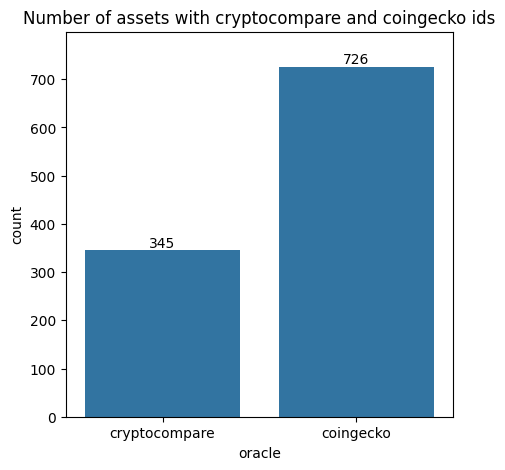

In [26]:
count_oracles = pl.DataFrame(api_oracles.select(pl.col('cryptocompare', 'coingecko').is_not_null().sum()).to_pandas().T.reset_index()).rename({'index': 'oracle', '0': 'count'})
oracles_data = count_oracles
ax = sns.barplot(x='oracle', y='count', data=oracles_data)
ax.figure.set_size_inches(5,5)
ax.margins(y=0.1) # make room for the labels
ax.set_title('Number of assets with cryptocompare and coingecko ids')
ax.bar_label(ax.containers[0])
ax

As we can see most of them have at least one oracle and again coingecko is the one listing most of them.

## Collections of assets <a id="collections"></a>

It is also useful to group tokens that are the same asset but in different chains. This is the case for example for USDC in ethereum, optimism, gnosis etc. It can happen also that the name/symbol is not the same in all these chains. For example USDC has USDC in ethereum but USD//C in gnosis. To overcome these UX issues we created collections that define a common name and symbol and then we map each token to a collection.


In [27]:
asset_collections = pl.read_csv('asset_collections.csv')

In [28]:
asset_collections.head(), len(asset_collections)

(shape: (5, 3)
 ┌────────────┬─────────────────────┬────────┐
 │ identifier ┆ name                ┆ symbol │
 │ ---        ┆ ---                 ┆ ---    │
 │ i64        ┆ str                 ┆ str    │
 ╞════════════╪═════════════════════╪════════╡
 │ 0          ┆ 0xBitcoin           ┆ 0xBTC  │
 │ 1          ┆ 1INCH Token         ┆ 1INCH  │
 │ 2          ┆ Aave Token          ┆ AAVE   │
 │ 3          ┆ AdEx Network        ┆ ADX    │
 │ 4          ┆ AllianceBlock Token ┆ ALBT   │
 └────────────┴─────────────────────┴────────┘,
 238)

As you can see at the moment we have 238 collection of assets. For the total number of assets mapped we have

In [29]:
multiassets_mappings = pl.read_csv('multiassets_mappings.csv')

In [30]:
multiassets_mappings.head(), len(multiassets_mappings)

(shape: (5, 2)
 ┌───────────────────────┬───────────────────────────────────┐
 │ collection_identifier ┆ asset                             │
 │ ---                   ┆ ---                               │
 │ i64                   ┆ str                               │
 ╞═══════════════════════╪═══════════════════════════════════╡
 │ 0                     ┆ eip155:10/erc20:0xe0BB0D3DE8c109… │
 │ 0                     ┆ eip155:137/erc20:0x71B821aa52a49… │
 │ 0                     ┆ eip155:1/erc20:0xB6eD7644C69416d… │
 │ 0                     ┆ eip155:42161/erc20:0x7cb16cb78ea… │
 │ 1                     ┆ eip155:43114/erc20:0xd501281565b… │
 └───────────────────────┴───────────────────────────────────┘,
 615)

Those mappings include assets across different chains. This part of the dataset is one of the most recent additions and it is growing with each release.

In [31]:
multiassets_mappings.group_by('collection_identifier').count().select('count').describe()

describe,count
str,f64
"""count""",238.0
"""null_count""",0.0
"""mean""",2.584034
"""std""",1.109642
"""min""",1.0
"""25%""",2.0
"""50%""",2.0
"""75%""",3.0
"""max""",10.0


For the groups the mean is to have ~2.6 assets in each collection and the max value is 10 assets in a single collection. At rotki we believe this information is really useful for users and can help others to improve the UX in their apps too.

## Conclusion <a id="conclusion"></a>

This dataset provides what we believe is useful information to any project that wants to use it. The data was collected over multiple years and it provides an interesting perspective for how assets were created over time and peculiarities that they have. Hopefuly it can be useful for your project too or for learning more about the ecosystem.

If you want to improve the database quality or you have ideas on things to improve feel free to join the discussion at https://discord.rotki.com/

imagen.png